## Setup

In [109]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [110]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [111]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

In [112]:
data = pd.read_csv("classified_spam.csv")
# text = data["text"]
# is_spam = data["label_num"]
# text_class = data["classification"] 

TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label_num'

def df_to_tf_dataset(df, text_column, label_column):
    return tf.data.Dataset.from_tensor_slices((
        df[text_column].values,  # Features
        df[label_column].values   # Labels
    ))
    
    
max_vocab_size = 1000  # Adjust based on your data

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
)

# Fit the vectorizer
text_vectorization.adapt(data[TEXT_COLUMN])

def df_to_tf_vec_dataset(df, text_column, label_column):
    return tf.data.Dataset.from_tensor_slices((
        pad_sequences(text_vectorization(df[TEXT_COLUMN].tolist()), padding='post'),  # Features
        df[label_column].values   # Labels
    ))
    
dataset = df_to_tf_dataset(data, TEXT_COLUMN, LABEL_COLUMN)

train_size = int(len(data) * 0.8)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Specify output types
train_dataset = train_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types
test_dataset = test_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types

Initially this returns a dataset of (text, label pairs):

In [113]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [114]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [115]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [116]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Subject: re : meter 1428\r\nwe should check with gas control as to why gas is flowing at all and / or\r\nwhether this is a valid reading . . . .\r\ngary / james - let us know\r\nthanks\r\nlee\r\naimee lannou 12 / 05 / 2000 11 : 09 am\r\nto : daren j farmer / hou / ect @ ect\r\ncc : lee l papayoti / hou / ect @ ect\r\nsubject : meter 1428\r\ndaren - meter 1428 , beaumont methanol is shut - in for december . there has\r\nbeen flow of 69 and 65 on days 2 and 3 . should a swing ticket be put at the\r\nmeter ? the last swing deal was 451907 for 11 / 00 . thanks .\r\naimee'
 b'Subject: enron actuals\r\ndec . 21 , 2000\r\nteco tap 0 . 000 / enron ; 18 . 750 / hpl gas daily\r\ndec . 22 , 2000\r\nteco tap 30 . 000 / enron ; 80 . 417 / hpl gas daily\r\ndec . 23 , 2000\r\nteco tap 0 . 000 / enron ; 6 . 250 / hpl gas daily\r\ndec . 24 , 2000\r\nteco tap 40 . 000 / enron ; 110 . 000 / hpl gas daily\r\ndec . 25 , 2000\r\nteco tap 40 . 000 / enron ; 110 . 000 / hpl gas daily'
 b'Subject: s

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [117]:
VOCAB_SIZE = 1000
max_sequence_length = 20
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [118]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'a', 'in', 'for', 'is',
       'you', 'i', 'on', 'this', 'be', 'that', 'ect', 'will', 'with',
       'are'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [119]:
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)

[[ 30 113 107 ...   0   0   0]
 [ 30  34 906 ...   0   0   0]
 [ 30   1  24 ...   0   0   0]]


With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [120]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Subject: re : meter 1428\r\nwe should check with gas control as to why gas is flowing at all and / or\r\nwhether this is a valid reading . . . .\r\ngary / james - let us know\r\nthanks\r\nlee\r\naimee lannou 12 / 05 / 2000 11 : 09 am\r\nto : daren j farmer / hou / ect @ ect\r\ncc : lee l papayoti / hou / ect @ ect\r\nsubject : meter 1428\r\ndaren - meter 1428 , beaumont methanol is shut - in for december . there has\r\nbeen flow of 69 and 65 on days 2 and 3 . should a swing ticket be put at the\r\nmeter ? the last swing deal was 451907 for 11 / 00 . thanks .\r\naimee'
Round-trip:  subject re meter [UNK] we should check with gas control as to why gas is [UNK] at all and or whether this is a [UNK] reading gary james let us know thanks lee aimee [UNK] 12 05 2000 11 09 am to daren j farmer hou ect ect cc lee l [UNK] hou ect ect subject meter [UNK] daren meter [UNK] [UNK] [UNK] is [UNK] in for december there has been flow of [UNK] and [UNK] on days 2 and 3 should a [UNK] ticket

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [122]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [123]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
print(sample_text)
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions[0])

The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[0.01583572]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [124]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
[0.01583572]


Compile the Keras model to configure the training process:

In [140]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [141]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.7980 - loss: 0.5614 - val_accuracy: 0.8089 - val_loss: 0.3127
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.8356 - loss: 0.2753 - val_accuracy: 0.9370 - val_loss: 0.1675
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9387 - loss: 0.1719 - val_accuracy: 0.9422 - val_loss: 0.1460
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9518 - loss: 0.1393 - val_accuracy: 0.9526 - val_loss: 0.1261
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9581 - loss: 0.1117 - val_accuracy: 0.9516 - val_loss: 0.1228
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9623 - loss: 0.0973 - val_accuracy: 0.9615 - val_loss: 0.1144
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9676 - loss: 0.0893 - val_accuracy: 0.9505 - val_loss: 0.1237
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9675 - loss: 0.0839 - 

In [142]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9688 - loss: 0.0540

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1051
Test Loss: 0.10509982705116272
Test Accuracy: 0.9586945176124573


(0.0, 0.49910503514111043)

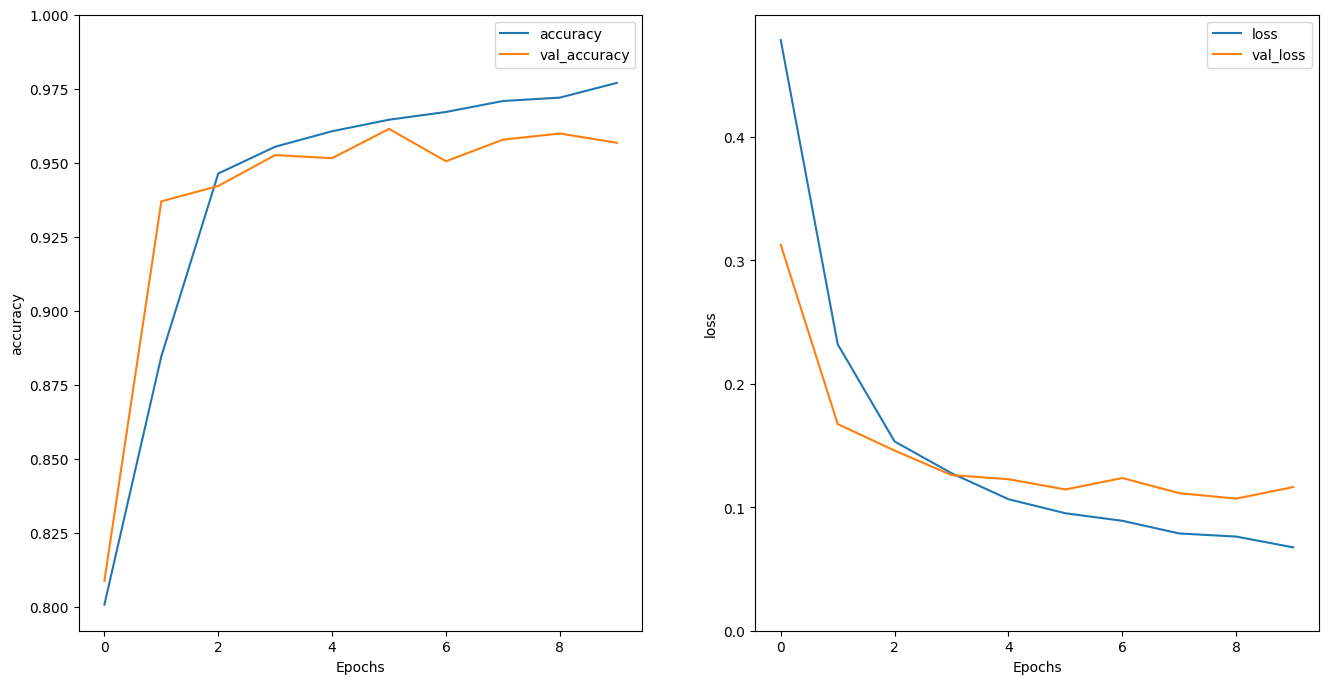

In [143]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [146]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
[-0.36030504]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [150]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [151]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [152]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - accuracy: 0.7913 - loss: 0.5529 - val_accuracy: 0.8089 - val_loss: 0.3099
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.8623 - loss: 0.2860 - val_accuracy: 0.9458 - val_loss: 0.1687
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9411 - loss: 0.1775 - val_accuracy: 0.9536 - val_loss: 0.1357
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.9563 - loss: 0.1340 - val_accuracy: 0.9510 - val_loss: 0.1320
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.9661 - loss: 0.1083 - val_accuracy: 0.9490 - val_loss: 0.1460
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9702 - loss: 0.0962 - val_accuracy: 0.9500 - val_loss: 0.1402
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.9766 - loss: 0.0808 - val_accuracy: 0.9620 - val_loss: 0.1163
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.9735 - loss: 0

In [153]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9735 - loss: 0.0897
Test Loss: 0.08835429698228836
Test Accuracy: 0.9747577905654907


In [155]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[[-2.6909614]]


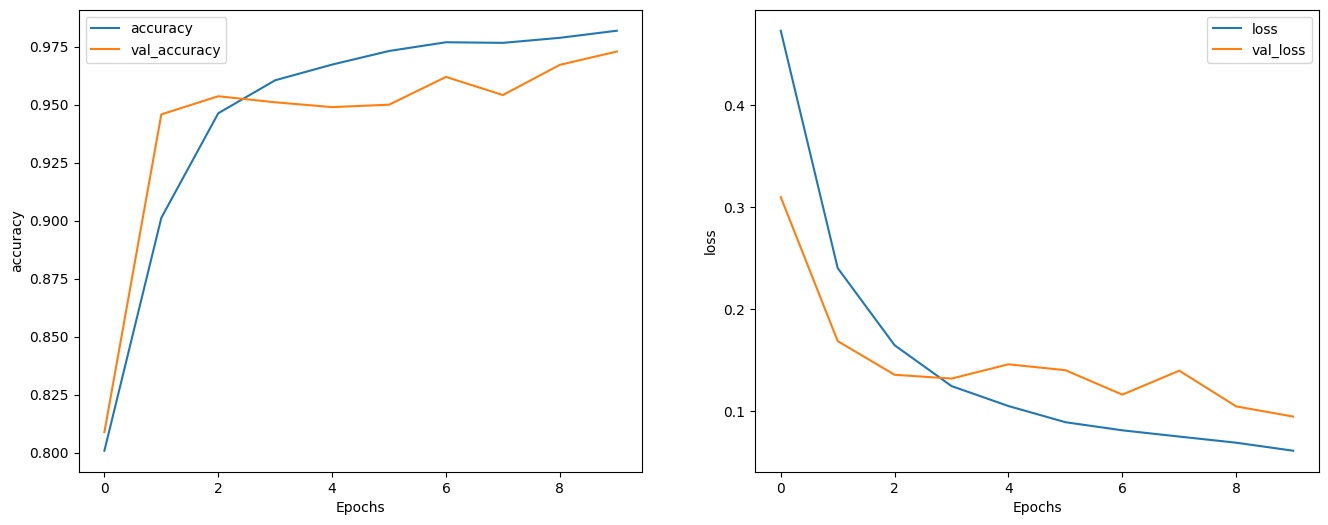

In [156]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
